# ECS 271 001 FQ 2023: Machine Learning and Discovery Project
### Project Title: Enabling Visual Accessibility: Leveraging Deep Learning Methodologies for Image Captioning
### Team Members: Shantanu Milind Joshi, Tejas Patil, Amritanand Sudheer Kumar

### Part 2: Fixing Xception as Encoder and Finding the Learning Rate that gives the best BLEU Score 

### Importing Libraries

In [1]:
# Import statements
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Importing BLUE Score for caption evaluation
from nltk.translate.bleu_score import corpus_bleu

# Importing Pretrained Xception CNN Model and it's Preprocessing Functions
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input

# Importing image and text preprocessing functions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers

# Importing other utilities like Model object, Layers from Keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add    

### Defining global constants

In [2]:
BASE_DIR = 'Dataset'
WORKING_DIR = ''
XCEPTION_ID = 'XCEPTION'

MODEL_NAME_MAP = {
    XCEPTION_ID: 'xception',
}

### Class to perprocess Text Captions and to initiate the use of Pre-trained CNN Model

In [3]:
class ImageCaptioningPreprocessorAndModelGenerator:

    def __init__(self, learning_rate, model_name=MODEL_NAME_MAP[XCEPTION_ID]):
        self.model_name = model_name
        self.learning_rate = learning_rate

    def load_model(self):
        
        # Selecting Xception as a default or base model
        model = Xception() 

        # Restructure the model to fetch the features from the image
        model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
        return model

    def extract_features_from_images(self, model, directory_path):
        # Creating a map of image id and feature
        all_image_features = {}
        index = 0
        for image_id_name in os.listdir(directory_path):
            image_path = os.path.join(directory_path, image_id_name)
            # Loading the preprocessed image from the give path
            loaded_image = self.load_and_preprocess_image(image_path)
            # Finding the features based on the selected model
            image_feature = model.predict(loaded_image, verbose=0)
            # Saving the feature in the map based on the id
            all_image_features[image_id_name.split('.')[0]] = image_feature
            
            index+=1
            
            if index % 1000 == 0:
                print(f"Completed extracting Features from {index} images")

        return all_image_features

    def load_and_preprocess_image(self, image_path):
        
        # Selecting Xception as a default or base model
        preprocessing_function  = xception_preprocess_input
        target_size_x = 299
        target_size_y = 299

        # Loading the image from a given path
        image = load_img(image_path, target_size=(target_size_x, target_size_y))
        # Converting the image to array
        image = img_to_array(image)
        # Preprocessing the loaded image
        image = self.preprocess_loaded_image(image, preprocessing_function)
        
        return image

    def preprocess_loaded_image(self, image, preprocessing_function):
        # Reshaping the image
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Preprocessing the image based on the selected model
        image = preprocessing_function(image)
        
        return image

    def save_features_to_pickle(self, features):
        # Saving the features extracted using the selected model
        pickle.dump(features, open(os.path.join(WORKING_DIR, f"{self.model_name}_lr_{self.learning_rate}_features.pkl"), 'wb'))

    def load_features_from_pickle(self):
        # Loading the features extractd using the selected model
        with open(os.path.join(WORKING_DIR, f"{self.model_name}_lr_{self.learning_rate}_features.pkl"), 'rb') as f:
            features = pickle.load(f)
        return features

    def load_captions_from_text_file(self, captions_file):
        # Reading the contents of the caption.txt file
        with open(captions_file, 'r') as f:
            next(f)
            captions_doc = f.read()
        return captions_doc

    def generate_image_to_caption_map(self, captions_doc):
        # Create a map for store image to captions
        image_to_caption_map = {}
        # Reading every single line
        for single_line in captions_doc.split('\n'):
            tokens = single_line.split(',')
            if len(single_line) < 2:
                continue
                
            # Splitting the line into image id and caption
            image_id, image_caption = tokens[0], tokens[1:]
            image_id = image_id.split('.')[0]
            image_caption = " ".join(image_caption)
            if image_id not in image_to_caption_map:
                image_to_caption_map[image_id] = []
            # Creating an array to store all the captions based on image id
            image_to_caption_map[image_id].append(image_caption)
        return image_to_caption_map

    def preprocess_captions(self, image_to_caption_map):
        # Preprocessing the captions by:
        # a. Removing the numbers from the captions, single letters (like a) and invalid captions like spaces
        # b. Adding the startseq and endseq for every caption
        for image_id, image_captions in image_to_caption_map.items():
            for i in range(len(image_captions)):
                single_caption_element = image_captions[i].lower()
                single_caption_element = single_caption_element.replace('[^A-Za-z]', '')
                single_caption_element = single_caption_element.replace('\s+', ' ')
                single_caption_element = 'startseq ' + " ".join([word for word in single_caption_element.split() if len(word) > 1]) + ' endseq'
                image_captions[i] = single_caption_element

    def tokenize_all_captions(self, all_captions):
        # Tokenizing the words
        tokenizer_obj = Tokenizer()
        tokenizer_obj.fit_on_texts(all_captions)
        # Finding the size of total vocabulary
        vocab_size = len(tokenizer_obj.word_index) + 1
        return tokenizer_obj, vocab_size

    def get_caption_with_max_length(self, all_captions):
        # Fetching the caption with maximum length, so that we can pad other captions
        return max(len(single_caption.split()) for single_caption in all_captions)
        
    def split_train_test_data(self, image_to_caption_map):
        # Splitting the data into train and test
        all_image_ids = list(image_to_caption_map.keys())
        split = int(len(all_image_ids) * 0.90)
        train_image_ids = all_image_ids[:split]
        test_image_ids = all_image_ids[split:]
        # Returning the ids of images after train and test split
        return train_image_ids, test_image_ids

### Class to implement the 2 Layer Encoder and 1 Layer Decoder Merge model architecture

In [4]:
class ImageCaptioningModelGenerator:

    # Initialize the ImageCaptioningModelGenerator
    def __init__(self, max_seq_length, vocab_size, learning_rate):
        self.max_seq_length = max_seq_length
        self.vocab_size = vocab_size
        self.learning_rate = learning_rate

    # Generator function to create batches of training data for the image captioning model
    def generate_data_batches(self, dataset_keys, caption_mapping, image_features, text_tokenizer, batch_size):
        while True:
            image_inputs, text_inputs, targets = list(), list(), list()
            batch_count = 0
            for key in dataset_keys:
                batch_count += 1
                captions = caption_mapping[key]
                for caption in captions:
                    seq = text_tokenizer.texts_to_sequences([caption])[0]
                    for i in range(1, len(seq)):
                        in_seq, out_seq = seq[:i], seq[i]
                        in_seq = pad_sequences([in_seq], maxlen=self.max_seq_length)[0]
                        out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                        image_inputs.append(image_features[key][0])
                        text_inputs.append(in_seq)
                        targets.append(out_seq)
                if batch_count == batch_size:
                    image_inputs, text_inputs, targets = np.array(image_inputs), np.array(text_inputs), np.array(targets)
                    yield [image_inputs, text_inputs], targets
                    image_inputs, text_inputs, targets = list(), list(), list()
                    batch_count = 0

    # Build and compile the image captioning model with Mixed Architecture(2 Encoder Layers+ 1 Decoder Layer)
    def model_builder(self, encoder_output_size):
        # Encoder Layer 1 CNN
        image_input = Input(shape=(encoder_output_size,))
        fe1 = Dropout(0.4)(image_input)
        fe2 = Dense(256, activation='relu')(fe1)

        # Encoder Layer 2 LSTM
        text_input = Input(shape=(self.max_seq_length,))
        se1 = Embedding(self.vocab_size, 256, mask_zero=True)(text_input)
        se2 = Dropout(0.4)(se1)
        se3 = LSTM(256)(se2)

        # Decoder Layer 1
        decoder1 = add([fe2, se3])
        decoder2 = Dense(256, activation='relu')(decoder1)
        output_layer = Dense(self.vocab_size, activation='softmax')(decoder2)

        model = Model(inputs=[image_input, text_input], outputs=output_layer)
        custom_optimizer = optimizers.Adam(learning_rate=self.learning_rate)
        
        # Using Adam Optimizer
        model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer)
        return model

### Class to generate the captions based on the model trained

In [5]:
class ImageCaptioningAnalyzer:
    
    # Initialize the ImageCaptioningAnalyzer
    def __init__(self, trained_model, text_tokenizer, max_seq_length):
        self.trained_model = trained_model
        self.text_tokenizer = text_tokenizer
        self.max_length = max_seq_length

    # Converting an integer index to the corresponding word using the tokenizer
    def index_to_word(self, integer):
        for word, index in self.text_tokenizer.word_index.items():
            if index == integer:
                return word
        return None

    # Generating a caption prediction for a given image
    def caption_predictor(self, image):
        # Initializing the first word of caption
        input_text = 'startseq'
        for _ in range(self.max_length):
            sequence = self.text_tokenizer.texts_to_sequences([input_text])[0]
            sequence = pad_sequences([sequence], self.max_length)
            predictions = self.trained_model.predict([image, sequence], verbose=0)
            predicted_word_index = np.argmax(predictions)
            # Next Predicted word for the caption
            predicted_word = self.index_to_word(predicted_word_index)
            if predicted_word is None or predicted_word == 'endseq':
                break
            input_text += " " + predicted_word
        return input_text

    # Generating and displaying captions for a given image.
    def caption_generator(self, image_filename, image_features, caption_mapping):
        image_id = image_filename.split('.')[0]
        img_path = os.path.join(BASE_DIR, "Images", image_filename)
        image = Image.open(img_path)
        captions = caption_mapping[image_id]
        print('************************************Actual Captions************************************')
        for caption in captions:
            print(caption)
        y_pred = self.caption_predictor(image_features[image_id])
        print('************************************Predicted Caption************************************')
        print(y_pred)
        plt.imshow(image)

### Function to calculate the BLEU Score

In [6]:
# To evaluate the BLEU-1 and BLEU-2 scores for captioning model
def calculate_bleu_score(test_image_ids, image_features, caption_mapping, caption_model):
    actual_captions, predicted_captions = list(), list()
    for key in test_image_ids:

        # Retrieve reference(actual) captions
        reference_captions = caption_mapping[key]
        
        # Generate predicted caption using model
        y_pred = caption_model.caption_predictor(image_features[key])

        # Tokenize reference and predicted captions
        reference_tokenized_captions = [caption.split() for caption in reference_captions]
        y_pred = y_pred.split()

        #collect actual and predicted captions
        actual_captions.append(reference_tokenized_captions)
        predicted_captions.append(y_pred)

    print("BLEU-1: %f" % corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0)))

### 1. Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0007

#### 1.a. Training using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0007

In [13]:
# Image Captioning and Preprocessing Model
learning_rate = 0.0007
image_caption_and_preprocess_model = ImageCaptioningPreprocessorAndModelGenerator(learning_rate, MODEL_NAME_MAP[XCEPTION_ID])
xception_model = image_caption_and_preprocess_model.load_model()

# Extract Image Features
print("Started extracting Features from images")
img_features = image_caption_and_preprocess_model.extract_features_from_images(xception_model, os.path.join(BASE_DIR, 'Images'))
print("Completed extracting Features from all images")

# Save Features to Pickle
image_caption_and_preprocess_model.save_features_to_pickle(img_features)

# Load the saved features from Pickle
img_features_loaded = image_caption_and_preprocess_model.load_features_from_pickle()

# Load Captions
print("Started loading captions")
captions_doc = image_caption_and_preprocess_model.load_captions_from_text_file(os.path.join(BASE_DIR, 'captions.txt'))
print("Completed loading captions")

# Create Image to captions Mapping
image_to_caption_mapping = image_caption_and_preprocess_model.generate_image_to_caption_map(captions_doc)

# Preprocess Captions as per selected CNN Model
image_caption_and_preprocess_model.preprocess_captions(image_to_caption_mapping)

# Tokenize Text
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer, vocab_size = image_caption_and_preprocess_model.tokenize_all_captions(all_captions)

# Get Max Caption Length for padding
max_caption_length = image_caption_and_preprocess_model.get_caption_with_max_length(all_captions)

# Split Train-Test Data
train_image_ids, test_image_ids = image_caption_and_preprocess_model.split_train_test_data(image_to_caption_mapping)

# CaptioningModelGenerator
captioning_model_generator = ImageCaptioningModelGenerator(max_caption_length, vocab_size, learning_rate)

# Build Mixed Architecture Model 
model = captioning_model_generator.model_builder(encoder_output_size=2048)

# Training the Mixed Architecture Model 
print(f"Started Training Model: {XCEPTION_ID}")
epochs = 20
steps = len(train_image_ids) // 32
xception_loss_points = []
for _ in range(epochs):
    
    # Building Data Generator
    data_generator = captioning_model_generator.generate_data_batches(train_image_ids, image_to_caption_mapping, img_features_loaded, tokenizer, batch_size=32)
    history = model.fit(data_generator, epochs=1, steps_per_epoch=steps, verbose=1)
    xception_loss_points.append(history.history['loss'])
    
# Saving the Model
model.save(os.path.join(WORKING_DIR, f'{MODEL_NAME_MAP[XCEPTION_ID]}_learning_rate_{learning_rate}_best_model.h5'))
print(f"Completed Training Model: {XCEPTION_ID}")

Started extracting Features from images
Completed extracting Features from 1000 images
Completed extracting Features from 2000 images
Completed extracting Features from 3000 images
Completed extracting Features from 4000 images
Completed extracting Features from 5000 images
Completed extracting Features from 6000 images
Completed extracting Features from 7000 images
Completed extracting Features from 8000 images
Completed extracting Features from all images
Started loading captions
Completed loading captions


2023-12-14 15:15:23.508752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Started Training Model: XCEPTION
227/227 [==============================] - 142s 618ms/step - loss: 5.5647


2023-12-14 15:17:45.281354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 612ms/step - loss: 4.2569


2023-12-14 15:20:04.357848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 140s 615ms/step - loss: 3.7884


2023-12-14 15:22:24.041894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 613ms/step - loss: 3.5326


2023-12-14 15:24:43.249584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 614ms/step - loss: 3.3454


2023-12-14 15:27:02.774100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 140s 615ms/step - loss: 3.1929


2023-12-14 15:29:22.532080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 614ms/step - loss: 3.0644


2023-12-14 15:31:42.042270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 140s 615ms/step - loss: 2.9538


2023-12-14 15:34:01.808829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 613ms/step - loss: 2.8574


2023-12-14 15:36:21.132502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 612ms/step - loss: 2.7714


2023-12-14 15:38:40.222623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 613ms/step - loss: 2.6946


2023-12-14 15:40:59.514175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 611ms/step - loss: 2.6248


2023-12-14 15:43:18.212600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 608ms/step - loss: 2.5604


2023-12-14 15:45:36.311153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 607ms/step - loss: 2.5059


2023-12-14 15:47:54.283799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 612ms/step - loss: 2.4518


2023-12-14 15:50:13.244864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 609ms/step - loss: 2.4035


2023-12-14 15:52:31.525470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 607ms/step - loss: 2.3606


2023-12-14 15:54:49.498078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 606ms/step - loss: 2.3198


2023-12-14 15:57:07.099073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 607ms/step - loss: 2.2822


2023-12-14 15:59:25.022220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 137s 605ms/step - loss: 2.2450
Completed Training Model: XCEPTION


#### 1.b. Calculating the BLEU Scores using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0007

In [14]:
# Creating an instance of ImageCaptioningAnalyzer
img_caption_analyzer = ImageCaptioningAnalyzer(model, tokenizer, max_caption_length)

# Evaluate Model with BLEU 1 and 2 Scores
calculate_bleu_score(test_image_ids, img_features_loaded, image_to_caption_mapping, img_caption_analyzer)

BLEU-1: 0.522568
BLEU-2: 0.325870


#### 1.c. Testing the Model Generated using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0007

************************************Actual Captions************************************
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
************************************Predicted Caption************************************
startseq dog runs through the grass


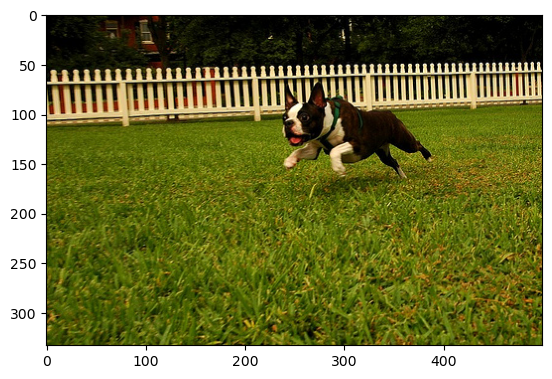

In [15]:
img_caption_analyzer.caption_generator("1009434119_febe49276a.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq boy carrying soccer ball endseq
startseq boy walks with ball tucked under his arm endseq
startseq boy walks with soccer ball near fence endseq
startseq boy wearing white t-shirt walks on the grass and carries soccer ball endseq
startseq small boy carries soccer ball on field endseq
************************************Predicted Caption************************************
startseq boy in red shirt and shorts is running on lawn


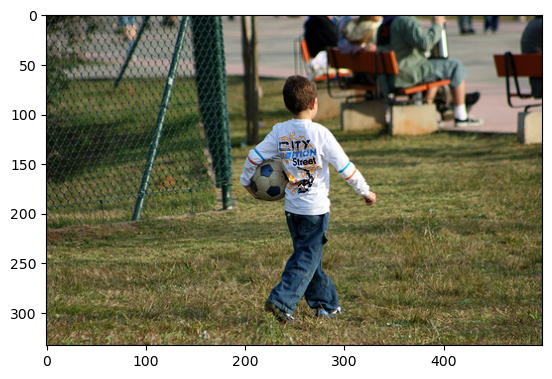

In [16]:
img_caption_analyzer.caption_generator("1104133405_c04a00707f.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man uses ice picks and crampons to scale ice endseq
startseq an ice climber in blue jacket and black pants is scaling frozen ice wall endseq
startseq an ice climber scaling frozen waterfall endseq
startseq person in blue and red ice climbing with two picks endseq
startseq climber climbing an ice wall endseq
************************************Predicted Caption************************************
startseq man in red coat is snowboarding


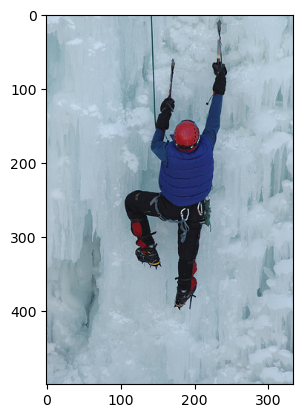

In [17]:
img_caption_analyzer.caption_generator("102455176_5f8ead62d5.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
************************************Predicted Caption************************************
startseq man in red kayak paddles down the water


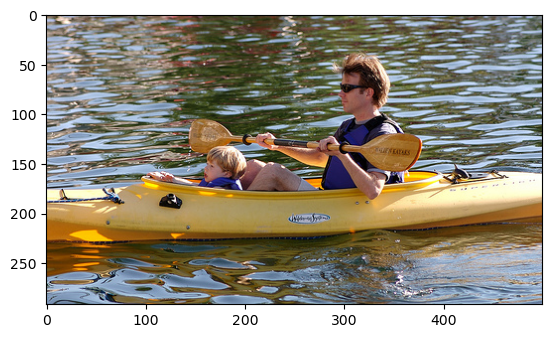

In [18]:
img_caption_analyzer.caption_generator("1028205764_7e8df9a2ea.jpg", img_features_loaded, image_to_caption_mapping)

### 2. Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.001

#### 2.a. Training using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.001

In [7]:
# Image Captioning and Preprocessing Model
learning_rate = 0.001
image_caption_and_preprocess_model = ImageCaptioningPreprocessorAndModelGenerator(learning_rate, MODEL_NAME_MAP[XCEPTION_ID])
xception_model = image_caption_and_preprocess_model.load_model()

# Extract Image Features
print("Started extracting Features from images")
img_features = image_caption_and_preprocess_model.extract_features_from_images(xception_model, os.path.join(BASE_DIR, 'Images'))
print("Completed extracting Features from all images")

# Save Features to Pickle
image_caption_and_preprocess_model.save_features_to_pickle(img_features)

# Load the saved features from Pickle
img_features_loaded = image_caption_and_preprocess_model.load_features_from_pickle()

# Load Captions
print("Started loading captions")
captions_doc = image_caption_and_preprocess_model.load_captions_from_text_file(os.path.join(BASE_DIR, 'captions.txt'))
print("Completed loading captions")

# Create Image to captions Mapping
image_to_caption_mapping = image_caption_and_preprocess_model.generate_image_to_caption_map(captions_doc)

# Preprocess Captions as per selected CNN Model
image_caption_and_preprocess_model.preprocess_captions(image_to_caption_mapping)

# Tokenize Text
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer, vocab_size = image_caption_and_preprocess_model.tokenize_all_captions(all_captions)

# Get Max Caption Length for padding
max_caption_length = image_caption_and_preprocess_model.get_caption_with_max_length(all_captions)

# Split Train-Test Data
train_image_ids, test_image_ids = image_caption_and_preprocess_model.split_train_test_data(image_to_caption_mapping)

# CaptioningModelGenerator
captioning_model_generator = ImageCaptioningModelGenerator(max_caption_length, vocab_size, learning_rate)

# Build Mixed Architecture Model 
model = captioning_model_generator.model_builder(encoder_output_size=2048)

# Training the Mixed Architecture Model 
print(f"Started Training Model: {XCEPTION_ID}")
epochs = 20
steps = len(train_image_ids) // 32
xception_loss_points = []
for _ in range(epochs):
    
    # Building Data Generator
    data_generator = captioning_model_generator.generate_data_batches(train_image_ids, image_to_caption_mapping, img_features_loaded, tokenizer, batch_size=32)
    history = model.fit(data_generator, epochs=1, steps_per_epoch=steps, verbose=1)
    xception_loss_points.append(history.history['loss'])
    
# Saving the Model
model.save(os.path.join(WORKING_DIR, f'{MODEL_NAME_MAP[XCEPTION_ID]}_learning_rate_{learning_rate}_best_model.h5'))
print(f"Completed Training Model: {XCEPTION_ID}")

Started extracting Features from images


2023-12-14 12:47:01.107378: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Completed extracting Features from 1000 images
Completed extracting Features from 2000 images
Completed extracting Features from 3000 images
Completed extracting Features from 4000 images
Completed extracting Features from 5000 images
Completed extracting Features from 6000 images
Completed extracting Features from 7000 images
Completed extracting Features from 8000 images
Completed extracting Features from all images
Started loading captions
Completed loading captions


2023-12-14 12:59:35.724455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Started Training Model: XCEPTION
227/227 [==============================] - 146s 639ms/step - loss: 5.3575


2023-12-14 13:02:02.108953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 151s 664ms/step - loss: 4.0636


2023-12-14 13:04:32.890754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 153s 673ms/step - loss: 3.6406


2023-12-14 13:07:05.746106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 152s 671ms/step - loss: 3.3794


2023-12-14 13:09:38.097035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 149s 655ms/step - loss: 3.1837


2023-12-14 13:12:06.768073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 151s 663ms/step - loss: 3.0253


2023-12-14 13:14:37.451976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 148s 650ms/step - loss: 2.8908


2023-12-14 13:17:05.143490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 147s 649ms/step - loss: 2.7768


2023-12-14 13:19:32.534970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 146s 644ms/step - loss: 2.6785


2023-12-14 13:21:58.841081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 635ms/step - loss: 2.5918


2023-12-14 13:24:23.131424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 147s 649ms/step - loss: 2.5174


2023-12-14 13:26:50.530251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 143s 628ms/step - loss: 2.4515


2023-12-14 13:29:13.211120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 634ms/step - loss: 2.3942


2023-12-14 13:31:37.320588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 143s 628ms/step - loss: 2.3414


2023-12-14 13:33:59.965213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 639ms/step - loss: 2.2930


2023-12-14 13:36:25.262433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 149s 656ms/step - loss: 2.2485


2023-12-14 13:38:54.139242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 151s 666ms/step - loss: 2.2064


2023-12-14 13:41:25.419384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 146s 644ms/step - loss: 2.1692


2023-12-14 13:43:51.559226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 151s 665ms/step - loss: 2.1334


2023-12-14 13:46:22.612217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 153s 673ms/step - loss: 2.1022
Completed Training Model: XCEPTION


#### 2.b. Calculating the BLEU Scores using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.001

In [8]:
# Creating an instance of ImageCaptioningAnalyzer
img_caption_analyzer = ImageCaptioningAnalyzer(model, tokenizer, max_caption_length)

# Evaluate Model with BLEU 1 and 2 Scores
calculate_bleu_score(test_image_ids, img_features_loaded, image_to_caption_mapping, img_caption_analyzer)

BLEU-1: 0.515412
BLEU-2: 0.321888


#### 2.c. Testing the Model Generated using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.001

************************************Actual Captions************************************
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
************************************Predicted Caption************************************
startseq black and white dog is jumping over red and white hurdle


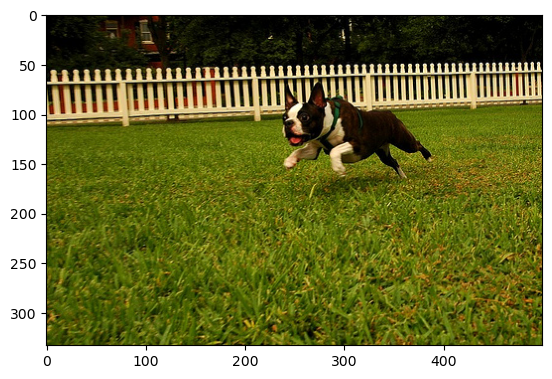

In [9]:
img_caption_analyzer.caption_generator("1009434119_febe49276a.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq boy carrying soccer ball endseq
startseq boy walks with ball tucked under his arm endseq
startseq boy walks with soccer ball near fence endseq
startseq boy wearing white t-shirt walks on the grass and carries soccer ball endseq
startseq small boy carries soccer ball on field endseq
************************************Predicted Caption************************************
startseq boy in blue shirt kicks soccer ball


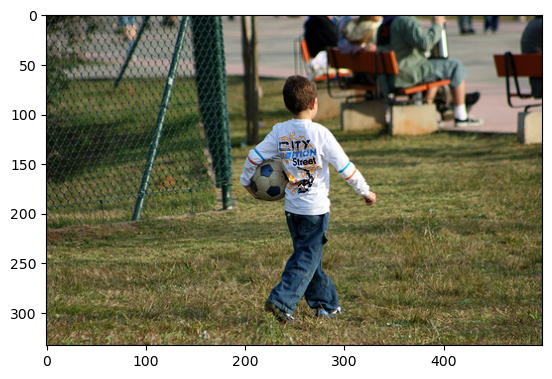

In [10]:
img_caption_analyzer.caption_generator("1104133405_c04a00707f.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man uses ice picks and crampons to scale ice endseq
startseq an ice climber in blue jacket and black pants is scaling frozen ice wall endseq
startseq an ice climber scaling frozen waterfall endseq
startseq person in blue and red ice climbing with two picks endseq
startseq climber climbing an ice wall endseq
************************************Predicted Caption************************************
startseq man in red and white snow gear is in the snow


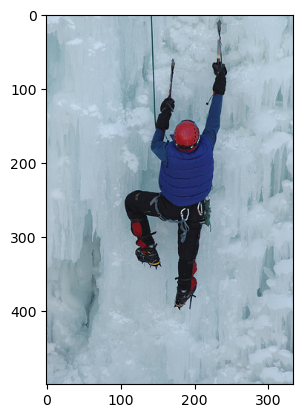

In [11]:
img_caption_analyzer.caption_generator("102455176_5f8ead62d5.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
************************************Predicted Caption************************************
startseq man in yellow kayak is paddling through the water


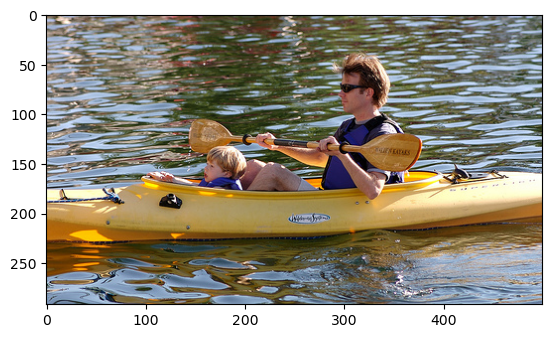

In [12]:
img_caption_analyzer.caption_generator("1028205764_7e8df9a2ea.jpg", img_features_loaded, image_to_caption_mapping)

### 3. Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0015

#### 3.a. Training using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0015

In [19]:
# Image Captioning and Preprocessing Model
learning_rate = 0.0015
image_caption_and_preprocess_model = ImageCaptioningPreprocessorAndModelGenerator(learning_rate, MODEL_NAME_MAP[XCEPTION_ID])
xception_model = image_caption_and_preprocess_model.load_model()

# Extract Image Features
print("Started extracting Features from images")
img_features = image_caption_and_preprocess_model.extract_features_from_images(xception_model, os.path.join(BASE_DIR, 'Images'))
print("Completed extracting Features from all images")

# Save Features to Pickle
image_caption_and_preprocess_model.save_features_to_pickle(img_features)

# Load the saved features from Pickle
img_features_loaded = image_caption_and_preprocess_model.load_features_from_pickle()

# Load Captions
print("Started loading captions")
captions_doc = image_caption_and_preprocess_model.load_captions_from_text_file(os.path.join(BASE_DIR, 'captions.txt'))
print("Completed loading captions")

# Create Image to captions Mapping
image_to_caption_mapping = image_caption_and_preprocess_model.generate_image_to_caption_map(captions_doc)

# Preprocess Captions as per selected CNN Model
image_caption_and_preprocess_model.preprocess_captions(image_to_caption_mapping)

# Tokenize Text
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer, vocab_size = image_caption_and_preprocess_model.tokenize_all_captions(all_captions)

# Get Max Caption Length for padding
max_caption_length = image_caption_and_preprocess_model.get_caption_with_max_length(all_captions)

# Split Train-Test Data
train_image_ids, test_image_ids = image_caption_and_preprocess_model.split_train_test_data(image_to_caption_mapping)

# CaptioningModelGenerator
captioning_model_generator = ImageCaptioningModelGenerator(max_caption_length, vocab_size, learning_rate)

# Build Mixed Architecture Model 
model = captioning_model_generator.model_builder(encoder_output_size=2048)

# Training the Mixed Architecture Model 
print(f"Started Training Model: {XCEPTION_ID}")
epochs = 20
steps = len(train_image_ids) // 32
xception_loss_points = []
for _ in range(epochs):
    
    # Building Data Generator
    data_generator = captioning_model_generator.generate_data_batches(train_image_ids, image_to_caption_mapping, img_features_loaded, tokenizer, batch_size=32)
    history = model.fit(data_generator, epochs=1, steps_per_epoch=steps, verbose=1)
    xception_loss_points.append(history.history['loss'])
    
# Saving the Model
model.save(os.path.join(WORKING_DIR, f'{MODEL_NAME_MAP[XCEPTION_ID]}_learning_rate_{learning_rate}_best_model.h5'))
print(f"Completed Training Model: {XCEPTION_ID}")

Started extracting Features from images
Completed extracting Features from 1000 images
Completed extracting Features from 2000 images
Completed extracting Features from 3000 images
Completed extracting Features from 4000 images
Completed extracting Features from 5000 images
Completed extracting Features from 6000 images
Completed extracting Features from 7000 images
Completed extracting Features from 8000 images
Completed extracting Features from all images
Started loading captions
Completed loading captions


2023-12-13 23:05:58.699819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Started Training Model: XCEPTION
227/227 [==============================] - 157s 684ms/step - loss: 5.2197


2023-12-13 23:08:35.388861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 154s 679ms/step - loss: 3.9202


2023-12-13 23:11:09.720202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 150s 660ms/step - loss: 3.4996


2023-12-13 23:13:39.610974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 153s 673ms/step - loss: 3.2428


2023-12-13 23:16:12.561478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 154s 676ms/step - loss: 3.0551


2023-12-13 23:18:46.236389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 147s 646ms/step - loss: 2.9038


2023-12-13 23:21:13.081884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 639ms/step - loss: 2.7758


2023-12-13 23:23:38.320828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 640ms/step - loss: 2.6711


2023-12-13 23:26:03.626825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 153s 674ms/step - loss: 2.5836


2023-12-13 23:28:36.671165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 139s 613ms/step - loss: 2.5006


2023-12-13 23:30:55.985400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 609ms/step - loss: 2.4338


2023-12-13 23:33:14.356844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 143s 630ms/step - loss: 2.3733


2023-12-13 23:35:37.508711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 149s 657ms/step - loss: 2.3186


2023-12-13 23:38:06.679555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 142s 626ms/step - loss: 2.2697


2023-12-13 23:40:28.967064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 143s 631ms/step - loss: 2.2238


2023-12-13 23:42:52.304900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 142s 625ms/step - loss: 2.1878


2023-12-13 23:45:14.357885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 141s 622ms/step - loss: 2.1511


2023-12-13 23:47:35.609272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 142s 627ms/step - loss: 2.1149


2023-12-13 23:49:57.909669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 143s 628ms/step - loss: 2.0826


2023-12-13 23:52:20.550437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 142s 624ms/step - loss: 2.0530
Completed Training Model: XCEPTION


#### 3.b. Calculating the BLEU Scores using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0015

In [20]:
# Creating an instance of ImageCaptioningAnalyzer
img_caption_analyzer = ImageCaptioningAnalyzer(model, tokenizer, max_caption_length)

# Evaluate Model with BLEU 1 and 2 Scores
calculate_bleu_score(test_image_ids, img_features_loaded, image_to_caption_mapping, img_caption_analyzer)

BLEU-1: 0.492248
BLEU-2: 0.298757


#### 3.c. Testing the Model Generated using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.0015

************************************Actual Captions************************************
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
************************************Predicted Caption************************************
startseq dog is running through the grass


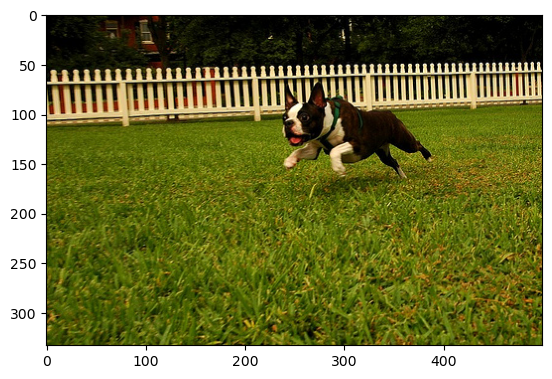

In [21]:
img_caption_analyzer.caption_generator("1009434119_febe49276a.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq boy carrying soccer ball endseq
startseq boy walks with ball tucked under his arm endseq
startseq boy walks with soccer ball near fence endseq
startseq boy wearing white t-shirt walks on the grass and carries soccer ball endseq
startseq small boy carries soccer ball on field endseq
************************************Predicted Caption************************************
startseq boy in blue shirt and blue shorts kicking soccer ball


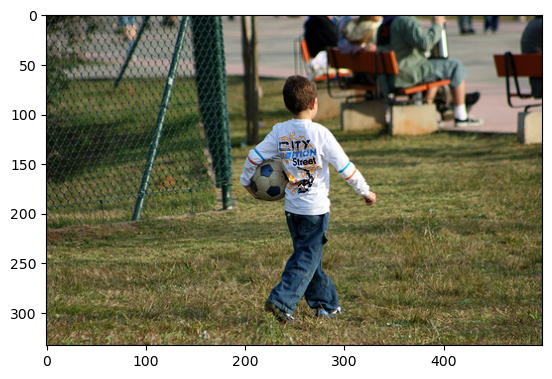

In [22]:
img_caption_analyzer.caption_generator("1104133405_c04a00707f.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man uses ice picks and crampons to scale ice endseq
startseq an ice climber in blue jacket and black pants is scaling frozen ice wall endseq
startseq an ice climber scaling frozen waterfall endseq
startseq person in blue and red ice climbing with two picks endseq
startseq climber climbing an ice wall endseq
************************************Predicted Caption************************************
startseq man in red coat is climbing up snowy hill


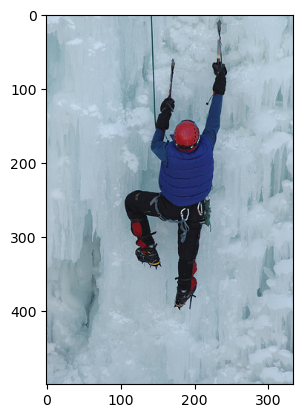

In [23]:
img_caption_analyzer.caption_generator("102455176_5f8ead62d5.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
************************************Predicted Caption************************************
startseq man in life jacket paddling kayak through the water


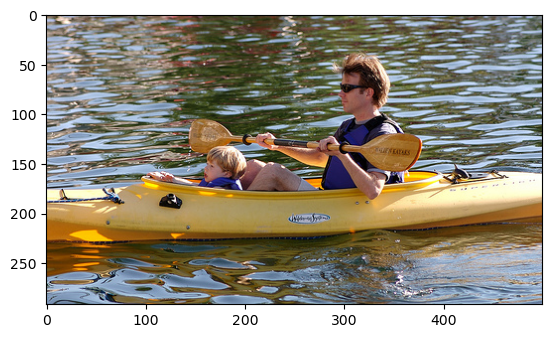

In [24]:
img_caption_analyzer.caption_generator("1028205764_7e8df9a2ea.jpg", img_features_loaded, image_to_caption_mapping)

### 4. Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.002

#### 4.a. Training using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.002

In [25]:
# Image Captioning and Preprocessing Model
learning_rate = 0.002
image_caption_and_preprocess_model = ImageCaptioningPreprocessorAndModelGenerator(learning_rate, MODEL_NAME_MAP[XCEPTION_ID])
xception_model = image_caption_and_preprocess_model.load_model()

# Extract Image Features
print("Started extracting Features from images")
img_features = image_caption_and_preprocess_model.extract_features_from_images(xception_model, os.path.join(BASE_DIR, 'Images'))
print("Completed extracting Features from all images")

# Save Features to Pickle
image_caption_and_preprocess_model.save_features_to_pickle(img_features)

# Load the saved features from Pickle
img_features_loaded = image_caption_and_preprocess_model.load_features_from_pickle()

# Load Captions
print("Started loading captions")
captions_doc = image_caption_and_preprocess_model.load_captions_from_text_file(os.path.join(BASE_DIR, 'captions.txt'))
print("Completed loading captions")

# Create Image to captions Mapping
image_to_caption_mapping = image_caption_and_preprocess_model.generate_image_to_caption_map(captions_doc)

# Preprocess Captions as per selected CNN Model
image_caption_and_preprocess_model.preprocess_captions(image_to_caption_mapping)

# Tokenize Text
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer, vocab_size = image_caption_and_preprocess_model.tokenize_all_captions(all_captions)

# Get Max Caption Length for padding
max_caption_length = image_caption_and_preprocess_model.get_caption_with_max_length(all_captions)

# Split Train-Test Data
train_image_ids, test_image_ids = image_caption_and_preprocess_model.split_train_test_data(image_to_caption_mapping)

# CaptioningModelGenerator
captioning_model_generator = ImageCaptioningModelGenerator(max_caption_length, vocab_size, learning_rate)

# Build Mixed Architecture Model 
model = captioning_model_generator.model_builder(encoder_output_size=2048)

# Training the Mixed Architecture Model 
print(f"Started Training Model: {XCEPTION_ID}")
epochs = 20
steps = len(train_image_ids) // 32
xception_loss_points = []
for _ in range(epochs):
    
    # Building Data Generator
    data_generator = captioning_model_generator.generate_data_batches(train_image_ids, image_to_caption_mapping, img_features_loaded, tokenizer, batch_size=32)
    history = model.fit(data_generator, epochs=1, steps_per_epoch=steps, verbose=1)
    xception_loss_points.append(history.history['loss'])
    
# Saving the Model
model.save(os.path.join(WORKING_DIR, f'{MODEL_NAME_MAP[XCEPTION_ID]}_learning_rate_{learning_rate}_best_model.h5'))
print(f"Completed Training Model: {XCEPTION_ID}")

Started extracting Features from images
Completed extracting Features from 1000 images
Completed extracting Features from 2000 images
Completed extracting Features from 3000 images
Completed extracting Features from 4000 images
Completed extracting Features from 5000 images
Completed extracting Features from 6000 images
Completed extracting Features from 7000 images
Completed extracting Features from 8000 images
Completed extracting Features from all images
Started loading captions
Completed loading captions


2023-12-14 00:13:33.827370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Started Training Model: XCEPTION
227/227 [==============================] - 143s 622ms/step - loss: 5.0954


2023-12-14 00:15:56.406036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 141s 623ms/step - loss: 3.8316


2023-12-14 00:18:17.957184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 141s 621ms/step - loss: 3.4182


2023-12-14 00:20:39.072764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 140s 616ms/step - loss: 3.1643


2023-12-14 00:22:59.099338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 633ms/step - loss: 2.9811


2023-12-14 00:25:22.807027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 632ms/step - loss: 2.8393


2023-12-14 00:27:46.374058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 638ms/step - loss: 2.7286


2023-12-14 00:30:11.228194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 638ms/step - loss: 2.6340


2023-12-14 00:32:36.197367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 641ms/step - loss: 2.5516


2023-12-14 00:35:01.671654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 638ms/step - loss: 2.4762


2023-12-14 00:37:26.561797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 638ms/step - loss: 2.4157


2023-12-14 00:39:51.486177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 638ms/step - loss: 2.3574


2023-12-14 00:42:16.439000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 146s 645ms/step - loss: 2.3006


2023-12-14 00:44:42.859989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 639ms/step - loss: 2.2560


2023-12-14 00:47:07.911181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 636ms/step - loss: 2.2197


2023-12-14 00:49:32.345950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 145s 638ms/step - loss: 2.1847


2023-12-14 00:51:57.167342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 146s 643ms/step - loss: 2.1541


2023-12-14 00:54:23.259022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 634ms/step - loss: 2.1189


2023-12-14 00:56:47.223635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 146s 645ms/step - loss: 2.0868


2023-12-14 00:59:13.691540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 146s 641ms/step - loss: 2.0616
Completed Training Model: XCEPTION


#### 4.b. Calculating the BLEU Scores using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.002

In [26]:
# Creating an instance of ImageCaptioningAnalyzer
img_caption_analyzer = ImageCaptioningAnalyzer(model, tokenizer, max_caption_length)

# Evaluate Model with BLEU 1 and 2 Scores
calculate_bleu_score(test_image_ids, img_features_loaded, image_to_caption_mapping, img_caption_analyzer)

BLEU-1: 0.480784
BLEU-2: 0.285512


#### 4.c. Testing the Model Generated using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.002

************************************Actual Captions************************************
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
************************************Predicted Caption************************************
startseq dog is running through the grass


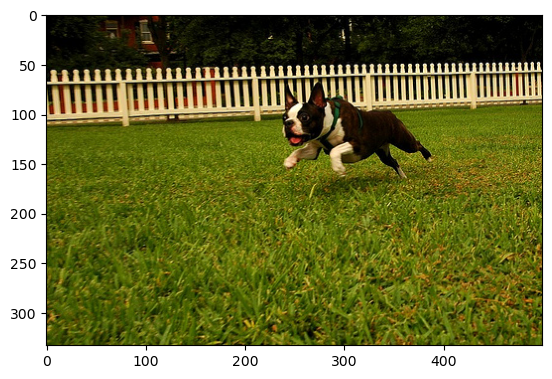

In [27]:
img_caption_analyzer.caption_generator("1009434119_febe49276a.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq boy carrying soccer ball endseq
startseq boy walks with ball tucked under his arm endseq
startseq boy walks with soccer ball near fence endseq
startseq boy wearing white t-shirt walks on the grass and carries soccer ball endseq
startseq small boy carries soccer ball on field endseq
************************************Predicted Caption************************************
startseq boy in red shirt and blue shorts plays with soccer ball


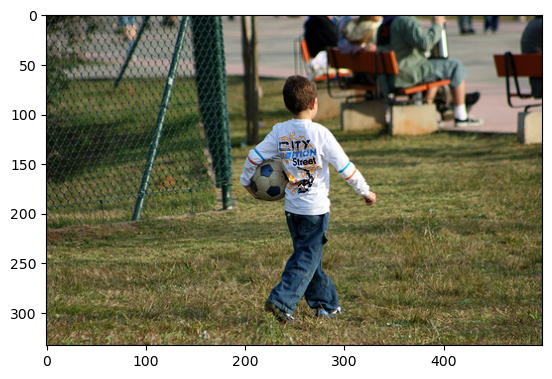

In [28]:
img_caption_analyzer.caption_generator("1104133405_c04a00707f.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man uses ice picks and crampons to scale ice endseq
startseq an ice climber in blue jacket and black pants is scaling frozen ice wall endseq
startseq an ice climber scaling frozen waterfall endseq
startseq person in blue and red ice climbing with two picks endseq
startseq climber climbing an ice wall endseq
************************************Predicted Caption************************************
startseq man in red jacket is snowboarding


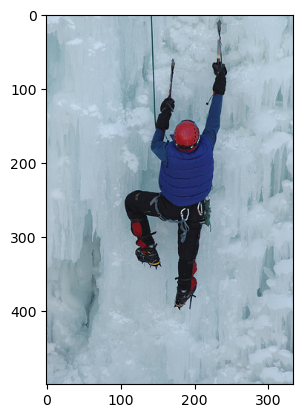

In [29]:
img_caption_analyzer.caption_generator("102455176_5f8ead62d5.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
************************************Predicted Caption************************************
startseq man in kayak is floating in the water


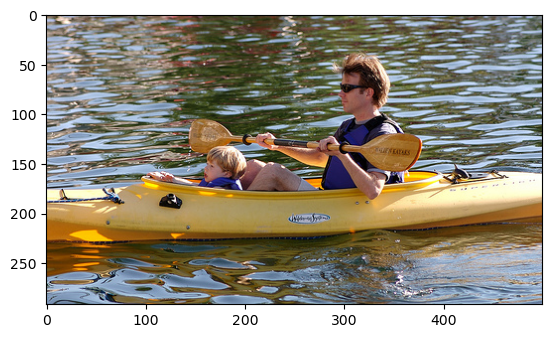

In [30]:
img_caption_analyzer.caption_generator("1028205764_7e8df9a2ea.jpg", img_features_loaded, image_to_caption_mapping)

### 5. Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.005

#### 5.a. Training using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.005

In [31]:
# Image Captioning and Preprocessing Model
learning_rate = 0.005
image_caption_and_preprocess_model = ImageCaptioningPreprocessorAndModelGenerator(learning_rate, MODEL_NAME_MAP[XCEPTION_ID])
xception_model = image_caption_and_preprocess_model.load_model()

# Extract Image Features
print("Started extracting Features from images")
img_features = image_caption_and_preprocess_model.extract_features_from_images(xception_model, os.path.join(BASE_DIR, 'Images'))
print("Completed extracting Features from all images")

# Save Features to Pickle
image_caption_and_preprocess_model.save_features_to_pickle(img_features)

# Load the saved features from Pickle
img_features_loaded = image_caption_and_preprocess_model.load_features_from_pickle()

# Load Captions
print("Started loading captions")
captions_doc = image_caption_and_preprocess_model.load_captions_from_text_file(os.path.join(BASE_DIR, 'captions.txt'))
print("Completed loading captions")

# Create Image to captions Mapping
image_to_caption_mapping = image_caption_and_preprocess_model.generate_image_to_caption_map(captions_doc)

# Preprocess Captions as per selected CNN Model
image_caption_and_preprocess_model.preprocess_captions(image_to_caption_mapping)

# Tokenize Text
all_captions = [caption for captions in image_to_caption_mapping.values() for caption in captions]
tokenizer, vocab_size = image_caption_and_preprocess_model.tokenize_all_captions(all_captions)

# Get Max Caption Length for padding
max_caption_length = image_caption_and_preprocess_model.get_caption_with_max_length(all_captions)

# Split Train-Test Data
train_image_ids, test_image_ids = image_caption_and_preprocess_model.split_train_test_data(image_to_caption_mapping)

# CaptioningModelGenerator
captioning_model_generator = ImageCaptioningModelGenerator(max_caption_length, vocab_size, learning_rate)

# Build Mixed Architecture Model 
model = captioning_model_generator.model_builder(encoder_output_size=2048)

# Training the Mixed Architecture Model 
print(f"Started Training Model: {XCEPTION_ID}")
epochs = 20
steps = len(train_image_ids) // 32
xception_loss_points = []
for _ in range(epochs):
    
    # Building Data Generator
    data_generator = captioning_model_generator.generate_data_batches(train_image_ids, image_to_caption_mapping, img_features_loaded, tokenizer, batch_size=32)
    history = model.fit(data_generator, epochs=1, steps_per_epoch=steps, verbose=1)
    xception_loss_points.append(history.history['loss'])
    
# Saving the Model
model.save(os.path.join(WORKING_DIR, f'{MODEL_NAME_MAP[XCEPTION_ID]}_learning_rate_{learning_rate}_best_model.h5'))
print(f"Completed Training Model: {XCEPTION_ID}")

Started extracting Features from images
Completed extracting Features from 1000 images
Completed extracting Features from 2000 images
Completed extracting Features from 3000 images
Completed extracting Features from 4000 images
Completed extracting Features from 5000 images
Completed extracting Features from 6000 images
Completed extracting Features from 7000 images
Completed extracting Features from 8000 images
Completed extracting Features from all images
Started loading captions
Completed loading captions


2023-12-14 01:19:36.051619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Started Training Model: XCEPTION
227/227 [==============================] - 137s 596ms/step - loss: 4.6880


2023-12-14 01:21:52.804975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 134s 590ms/step - loss: 3.6209


2023-12-14 01:24:06.872680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 134s 589ms/step - loss: 3.2961


2023-12-14 01:26:20.677578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 137s 605ms/step - loss: 3.0936


2023-12-14 01:28:38.176089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 633ms/step - loss: 2.9505


2023-12-14 01:31:02.094619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 141s 622ms/step - loss: 2.8428


2023-12-14 01:33:23.378976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 142s 626ms/step - loss: 2.7589


2023-12-14 01:35:45.575416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 146s 641ms/step - loss: 2.6943


2023-12-14 01:38:11.187977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 149s 656ms/step - loss: 2.6378


2023-12-14 01:40:40.108574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 150s 663ms/step - loss: 2.5907


2023-12-14 01:43:10.654438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 151s 664ms/step - loss: 2.5583


2023-12-14 01:45:41.437940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 149s 658ms/step - loss: 2.5294


2023-12-14 01:48:10.836662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 147s 646ms/step - loss: 2.5028


2023-12-14 01:50:37.654809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 148s 654ms/step - loss: 2.4672


2023-12-14 01:53:06.209874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 633ms/step - loss: 2.4392


2023-12-14 01:55:29.992891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 150s 663ms/step - loss: 2.4070


2023-12-14 01:58:00.490853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 144s 632ms/step - loss: 2.3836


2023-12-14 02:00:24.097679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 138s 607ms/step - loss: 2.3598


2023-12-14 02:02:41.960327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 134s 590ms/step - loss: 2.3427


2023-12-14 02:04:55.918107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 133s 586ms/step - loss: 2.3287
Completed Training Model: XCEPTION


#### 5.b. Calculating the BLEU Scores using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.005

In [32]:
# Creating an instance of ImageCaptioningAnalyzer
img_caption_analyzer = ImageCaptioningAnalyzer(model, tokenizer, max_caption_length)

# Evaluate Model with BLEU 1 and 2 Scores
calculate_bleu_score(test_image_ids, img_features_loaded, image_to_caption_mapping, img_caption_analyzer)

BLEU-1: 0.471727
BLEU-2: 0.278064


#### 5.c. Testing the Model Generated using Xception Encoder 1 and LSTM Encoder 2 with Learning Rate as 0.005

************************************Actual Captions************************************
startseq black and white dog is running in grassy garden surrounded by white fence endseq
startseq black and white dog is running through the grass endseq
startseq boston terrier is running in the grass endseq
startseq boston terrier is running on lush green grass in front of white fence endseq
startseq dog runs on the green grass near wooden fence endseq
************************************Predicted Caption************************************
startseq dog is jumping up to catch white ball


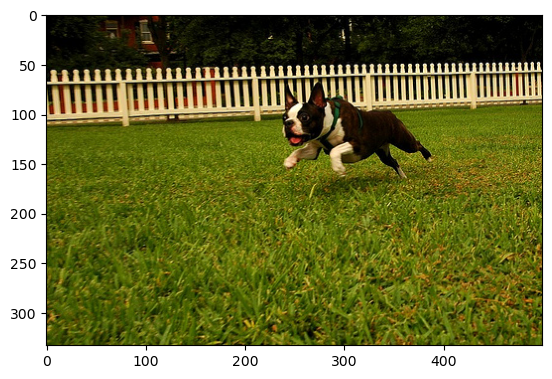

In [33]:
img_caption_analyzer.caption_generator("1009434119_febe49276a.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq boy carrying soccer ball endseq
startseq boy walks with ball tucked under his arm endseq
startseq boy walks with soccer ball near fence endseq
startseq boy wearing white t-shirt walks on the grass and carries soccer ball endseq
startseq small boy carries soccer ball on field endseq
************************************Predicted Caption************************************
startseq young boy wearing red shirt and hot pink pants plays with soccer ball


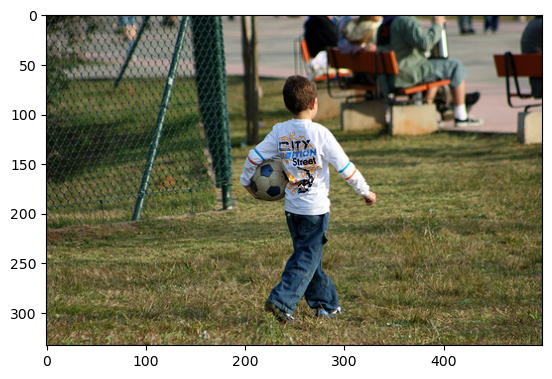

In [34]:
img_caption_analyzer.caption_generator("1104133405_c04a00707f.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man uses ice picks and crampons to scale ice endseq
startseq an ice climber in blue jacket and black pants is scaling frozen ice wall endseq
startseq an ice climber scaling frozen waterfall endseq
startseq person in blue and red ice climbing with two picks endseq
startseq climber climbing an ice wall endseq
************************************Predicted Caption************************************
startseq two people are standing on snowy mountain


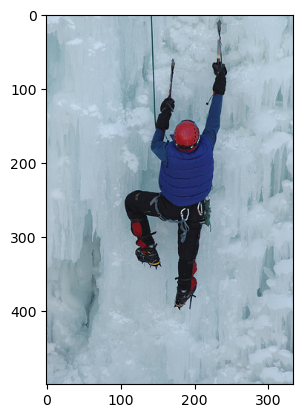

In [35]:
img_caption_analyzer.caption_generator("102455176_5f8ead62d5.jpg", img_features_loaded, image_to_caption_mapping)

************************************Actual Captions************************************
startseq man and baby are in yellow kayak on water endseq
startseq man and little boy in blue life jackets are rowing yellow canoe endseq
startseq man and child kayak through gentle waters endseq
startseq man and young boy ride in yellow kayak endseq
startseq man and child in yellow kayak endseq
************************************Predicted Caption************************************
startseq man in yellow canoe paddles through the rapids


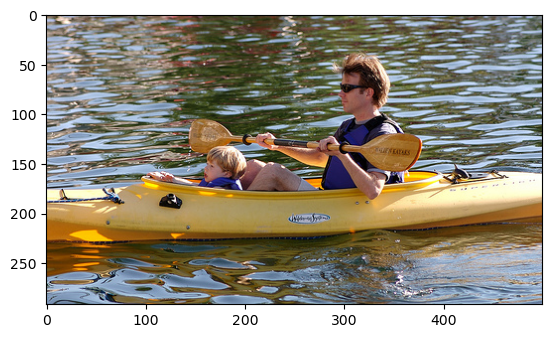

In [36]:
img_caption_analyzer.caption_generator("1028205764_7e8df9a2ea.jpg", img_features_loaded, image_to_caption_mapping)

### As seen above, the BLEU Score is the highest with learning rate as 0.0007